# Real-time processing with LibROSA's CQT

In [1]:
import numpy as np
import librosa as lr
from librosa.display import specshow
import matplotlib.pyplot as plt
%matplotlib inline

hop_length = 1024
sample_rate = 44100
audio = lr.load(lr.util.example_audio_file(), sr=sample_rate, duration=10.0)[0]

cqt = lambda *args, **kwargs: lr.cqt(*args, 
                                     sr=sample_rate, 
                                     hop_length=hop_length, 
                                     tuning=0, 
                                     sparsity=0, 
                                     n_bins=336, 
                                     bins_per_octave=48, 
                                     **kwargs)

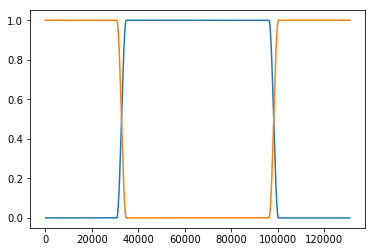

In [2]:
# Construct Tukey window for overlap-add.
N = 2**16
M = 4096
w = np.hanning(2 * M)
w = np.pad(w, (N - M) // 2, 'constant', constant_values=0)
w = np.roll(w, (N + M) // 2)
w = np.pad(w, (N - M) // 2, 'constant', constant_values=1)
w = np.roll(w, N)
plt.plot(w)
plt.plot(np.roll(w, N))
plt.show()

In [3]:
# Make signal a multiple of 2N by zero padding.
y = np.pad(audio, 2 * N - len(audio) % (2 * N), 'constant')

In [4]:
# Step through audio in blocks and apply CQT with 50% overlap.
spectrogram = []
frame = None
for i in range(0, len(audio), N):
    block = y[i:i + 2 * N]
    block = np.pad(block, N - len(block) // 2, 'constant')
    block *= w

    new_frame = np.abs(cqt(block))
    n = new_frame.shape[1] // 2
    if frame is not None:
        spectrogram.append(frame[:, n:] + new_frame[:, :n + 1])
    else:
        spectrogram.append(new_frame[:, :n])

    frame = new_frame
spectrogram = np.hstack(spectrogram)
frame = None

(336, 454) (336, 454)


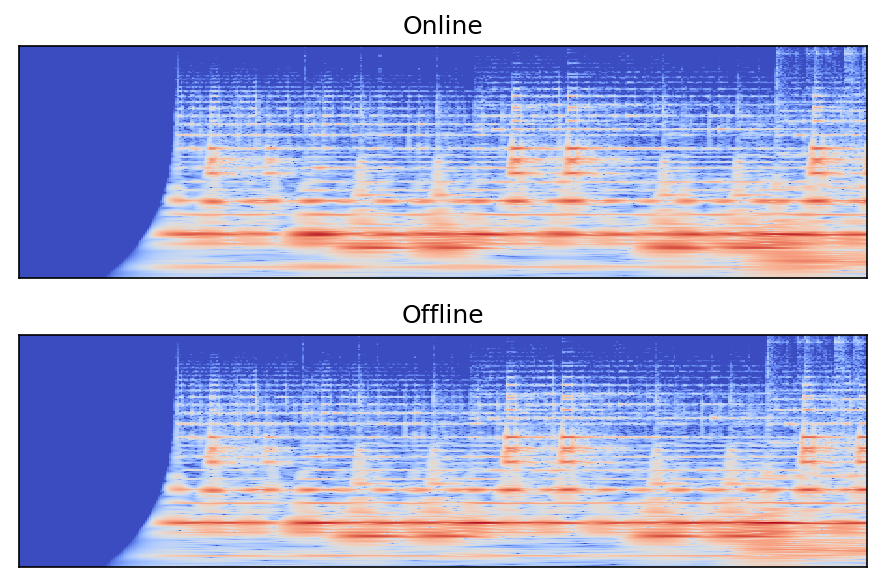

In [5]:
plt.figure(dpi=150)

z = cqt(y)[:, :spectrogram.shape[1]]

print(z.shape, spectrogram.shape)
plt.subplot(211)
specshow(lr.amplitude_to_db(spectrogram))
plt.title('Online')

plt.subplot(212)
specshow(lr.amplitude_to_db(z))
plt.title('Offline')

plt.tight_layout()